In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run imports.py

In [3]:
from tqdm.notebook import tqdm

In [3]:
def get_mrs_fitness(x, mrs, optim_fn, n_samples=None):
    for _ in range(x.ndim):
        mrs = mrs[..., None]
    shape = list(x.shape)
    if n_samples is not None:
        shape = [n_samples] + shape
        mrs = mrs[..., None]
    xmut = x+torch.randn(shape).to(x)*mrs
    fit_diff = optim_fn(xmut) - optim_fn(x)
    return x, xmut, fit_diff

def get_optimal_mr_extreme(x, mrs, optim_fn, n_samples=None):
    x, xmut, fit_diff = get_mrs_fitness(x, mrs, optim_fn, n_samples)
    return mrs[fit_diff.min(dim=-1).values.argmin(dim=0)]

def get_optimal_mr_look_ahead(x, mrs, optim_fn, n_gen=10, n_samples=1):
    if x.ndim==2:
        x = x[None]
    f = []
    for xi in x:
        for mr in mrs:
            for i in range(n_samples):
                pops, fits = optim.run_evolution_base(xi, optim_fn, n_gen, mr=mr)
                f.append(fits.min())
    f = torch.stack(f).reshape(len(x), len(mrs), n_samples)
    return mrs[f.mean(dim=-1).argmin(dim=-1)]

<ipython-input-30-7748dbf53469>:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x, y, z)


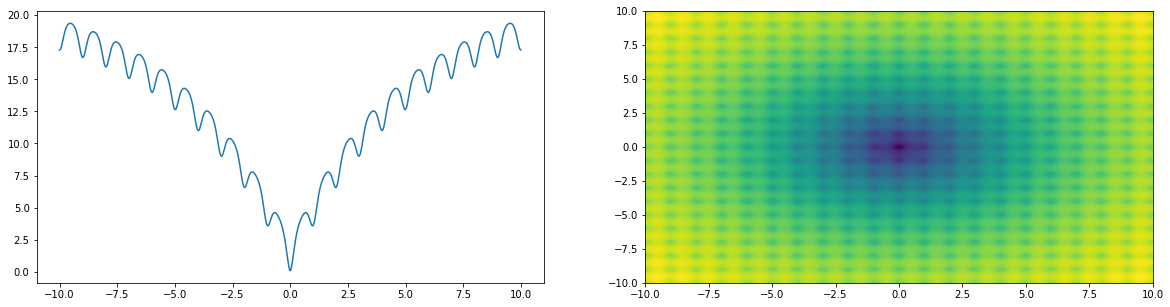

<ipython-input-30-7748dbf53469>:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x, y, z)


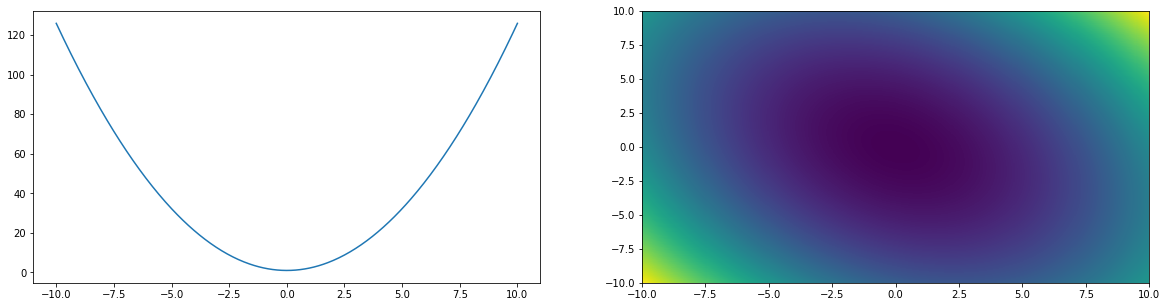

In [30]:
x = torch.linspace(-10, 10, 500)
y = torch.linspace(-10, 10, 500)
# x = torch.linspace(-500, 500, 1000)
# y = torch.linspace(-500, 500, 1000)
xm, ym = torch.meshgrid(x, y)

# for optim_fn in [ackley, rastrigin, myrastrigin, xin_she_yang, schwefel, zakharov, schaffer]:
for optim_fn in [ackley, zakharov]:
    plt.figure(figsize=(20, 5))
    plt.subplot(121)
    plt.plot(x, optim_fn(x[:, None]))
    plt.subplot(122)
    z = torch.stack([xm, ym], dim=-1)
    z = optim_fn(z)
    plt.pcolormesh(x, y, z)
    plt.show()
    

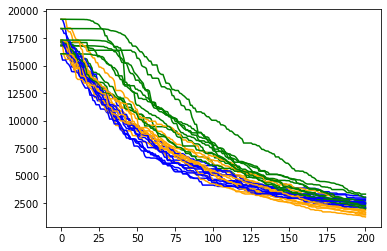

In [41]:
for i in range(10):
    pop = torch.randn(101, 100)*1000
    pops, fits = optim.run_evolution_base(pop, griewank, 200, mr=1e+2)
    plt.plot(fits.min(dim=-1).values, c='blue')
    pops, fits, mrs, _ = optim.run_evolution_ours(pop, griewank, 200)
    plt.plot(fits.min(dim=-1).values, c='orange')
    pops, fits, mrs = optim.run_evolution_ns(pop, griewank, 200)
    plt.plot(fits.min(dim=-1).values, c='green')

In [4]:
algos = ['ofmr', 'lamr_100', '1cmr', '15mr', 'ucb_5', 'ucb_10', 'nsmr', 'gsmr']
labels = ['OFMR', 'LAMR-100', '1CMR', '15MR', 'UCB/5', 'UCB/10', 'NSMR', 'GSMR']
colors = ['cornflowerblue', 'yellow', 'cyan', 'pink', 'purple', 'magenta', 'green', 'red']
algo2color = {algo: color for algo, color in zip(algos, colors)}
algo2label = {algo: label for algo, label in zip(algos, labels)}

log_mr_low, log_mr_high = -3, 0
mrs_grid_5 = torch.logspace(log_mr_low, log_mr_high, 5)
mrs_grid_10 = torch.logspace(log_mr_low, log_mr_high, 10)
mrs_grid_20 = torch.logspace(log_mr_low, log_mr_high, 20)

re_ofmr = partial(optim.run_evolution_ofmr, mrs=mrs_grid_10, n_sample=1)

re_la_10 = partial(optim.run_evolution_look_ahead, 
                    mrs=mrs_grid_10, look_ahead=10, every_k_gen=10, n_sims=1)
re_la_100 = partial(optim.run_evolution_look_ahead, 
                    mrs=mrs_grid_10, look_ahead=100, every_k_gen=100, n_sims=1)

def re_1c(pop, optim_fn, n_gen, k=.5, k_elite=None):
    mr = torch.tensor(1./pop.shape[-1]).to(pop)
    a = optim.run_evolution_base(pop, optim_fn, n_gen, mr, k=k, k_elite=k_elite)
    return list(a)+[mr.repeat(n_gen+1)]

re_15 = partial(optim.run_evolution_one_fifth, 
                mr=1e-2, mr_mut=1.01, thresh=0.2)

re_ucb_5 = partial(optim.run_evolution_ucb, mrs=mrs_grid_5)
re_ucb_10 = partial(optim.run_evolution_ucb, mrs=mrs_grid_10)

re_nsmr = partial(optim.run_evolution_ns,
                  mr=None, mr_mut=2.0)

re_gsmr = partial(optim.run_evolution_ours, 
                  n_mutpop=10, mr=None, mr_mut=2.0)

algo_fns = [re_ofmr, re_la_100, re_1c, re_15, re_ucb_5, re_ucb_10, re_nsmr, re_gsmr]
algo2algo_fn = {algo: algo_fn for algo, algo_fn in zip(algos, algo_fns)}

In [6]:
optim_fns = [ackley, rastrigin, rosenbrock, sphere, lin_fn]
n_dims = [2, 30, 100, 1000]
# init_pop_vars = [.1, 1, 5, 10]
init_pop_vars = [1, 10]
n_seed = 5
n_gen = 500
n_pop = 101

data = np.zeros((len(algos), len(optim_fns), len(n_dims), 
                 len(init_pop_vars), n_seed, n_gen+1, 2))
data = xr.DataArray(data, dims=('algo', 'optim_fn', 'n_dim', 
                                'init_pop_var', 'seed', 'gen', 'fits_mrs'),
                    coords={'algo': algos, 
                            'optim_fn': optim_fns,
                            'n_dim': n_dims,
                            'init_pop_var': init_pop_vars,
                            'seed': list(range(n_seed)),
                            'gen': list(range(n_gen+1)),
                            'fits_mrs': ['fits', 'mrs'],
                           })

pbar = tqdm(total=len(optim_fns)*len(n_dims)*len(init_pop_vars)*n_seed*len(algos))
for optim_fn in optim_fns:
    for n_dim in [30]:
        for init_pop_var in init_pop_vars:
            for seed in range(n_seed):
                pop = torch.randn(n_pop, n_dim)*init_pop_var
                for algo in algos:
                    res = algo2algo_fn[algo](pop, optim_fn, n_gen)
                    pops, fits, mrs = res[:3]
                    fits = fits.min(dim=-1).values
                    while mrs.ndim>1:
                        mrs = mrs.log().mean(dim=-1).exp()
                    
                    a = data.sel(algo=algo, optim_fn=optim_fn, n_dim=n_dim, 
                                 init_pop_var=init_pop_var, seed=seed)
                    
                    a.sel(fits_mrs='fits')[:] = fits.detach().cpu().numpy()
                    a.sel(fits_mrs='mrs')[:] = mrs.detach().cpu().numpy()
            
                    pbar.update(n=1); pbar.refresh()
torch.save(data, 'results/main_data.th')

  0%|          | 0/48 [00:00<?, ?it/s]

In [34]:
data = torch.load('results/main_data.th')
a = np.array(algos)[data.sel(gen=500, fits_mrs='fits').argmin(dim='algo').data]

In [35]:
for algo in algos:
    print(algo, (a==algo).sum())

ofmr 20
lamr_100 62
1cmr 0
15mr 10
ucb_5 8
ucb_10 2
nsmr 53
gsmr 45


In [75]:
# for optim_fn in [ackley, rastrigin, rosenbrock, sphere, lin_fn]:
for optim_fn in [ackley, rastrigin, rosenbrock, sphere]:
    print('\multirow{8}{*}{\\rotatebox[origin=c]{90}{'+optim_fn.__name__+'}}')
    for n_dim in [2, 30, 100, 1000]:
        print(' &\multirow{2}{*}{'+str(n_dim)+'-D}')
        for i, init_pop_var in enumerate([1, 10]):
            print('&' if i>0 else ' ', end='')
#             print(f'& {init_pop_var:2.1f} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\\\')
            print(f'& {init_pop_var:2.1f}')
            a = data.sel(optim_fn=optim_fn, 
                         n_dim=n_dim, init_pop_var=init_pop_var, 
                         fits_mrs='fits')[:, :, -1]
            a = np.array(algos)[a.mean(dim='seed').argsort().data]
            a = a[~np.logical_or(a=='lamr_100', a=='ofmr')]
            best_algo = a[0]
            for algo in algos:
                a = data.sel(algo=algo, optim_fn=optim_fn, 
                             n_dim=n_dim, init_pop_var=init_pop_var, 
                             fits_mrs='fits')[:, -1]
                a = a.mean().data
                if algo==best_algo:
                    
                    print(' & \\textbf{'+f'{a:1.02e}'+'}')
                else:
                    print(f' & {a:1.02e}', end='')
            print('\\\\')
    print('\\hline')

\multirow{8}{*}{\rotatebox[origin=c]{90}{ackley}}
 &\multirow{2}{*}{2-D}
 & 1.0
 & 9.16e-06 & 2.14e-05 & 1.12e-02 & 3.50e-04 & 2.51e-02 & 1.45e-02 & \textbf{0.00e+00}
 & 0.00e+00\\
&& 10.0
 & 5.17e-01 & 2.52e-05 & 1.70e-02 & 2.82e+00 & 2.22e-02 & 1.46e-02 & \textbf{0.00e+00}
 & 0.00e+00\\
 &\multirow{2}{*}{30-D}
 & 1.0
 & 8.10e-01 & 6.75e-03 & 2.27e+00 & 2.45e+00 & 2.18e+00 & 2.27e+00 & 2.23e+00 & \textbf{4.18e-01}
\\
&& 10.0
 & 2.62e+00 & 7.49e-03 & 1.48e+01 & 1.47e+01 & 3.01e+00 & 3.67e+00 & 1.11e+01 & \textbf{9.18e-01}
\\
 &\multirow{2}{*}{100-D}
 & 1.0
 & 2.98e+00 & 2.49e+00 & 3.01e+00 & 2.86e+00 & 3.33e+00 & 3.42e+00 & 2.95e+00 & \textbf{2.77e+00}
\\
&& 10.0
 & 5.75e+00 & 3.78e+00 & 1.61e+01 & 1.61e+01 & 8.57e+00 & 7.17e+00 & 1.61e+01 & \textbf{4.19e+00}
\\
 &\multirow{2}{*}{1000-D}
 & 1.0
 & 4.43e+00 & 4.36e+00 & 5.05e+00 & \textbf{4.37e+00}
 & 4.73e+00 & 4.74e+00 & 4.49e+00 & 4.44e+00\\
&& 10.0
 & 1.77e+01 & 1.80e+01 & 1.86e+01 & 1.80e+01 & 1.84e+01 & 1.84e+01 & 1.81e+01 & \text

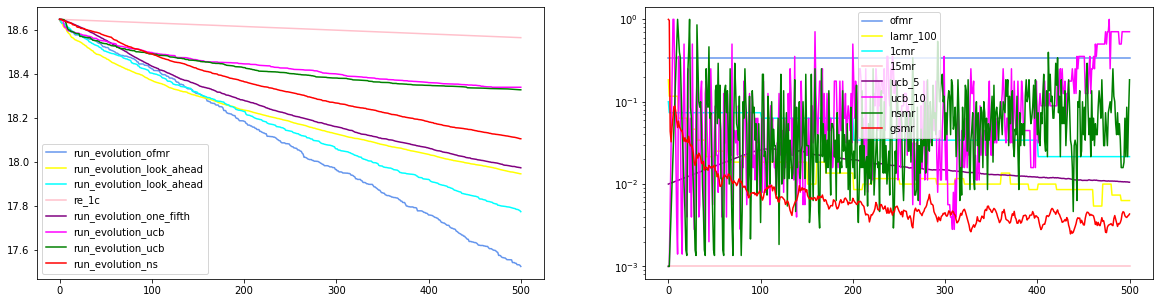

In [315]:
# algos_render = ['ofmr', 'lamr_100', '15mr', 'ucb_5', 'nsmr', 'gsmr']
plt.figure(figsize=(20,5))
plt.subplot(121)
for algo in algos:
    label = algo2algo_fn[algo]
    if type(algo2algo_fn[algo])==partial:
        label = label.func
    label = label.__name__
    a = data.sel(algo=algo, optim_fn=ackley, n_dim=1000, init_pop_var=10, fits_mrs='fits')
    viz.plot_mean_std(torch.from_numpy(a.data), label, algo2color[algo], False, 
                      render_mean=True, render_std=False, render_plots=False)
plt.subplot(122)
for algo in algos:
    label = algo
    a = data.sel(algo=algo, optim_fn=ackley, n_dim=1000, init_pop_var=10, fits_mrs='mrs')
    viz.plot_mean_std(torch.from_numpy(a.data), label, algo2color[algo], True, 
                      render_mean=True, render_std=False, render_plots=False)

  0%|          | 0/5 [00:00<?, ?it/s]

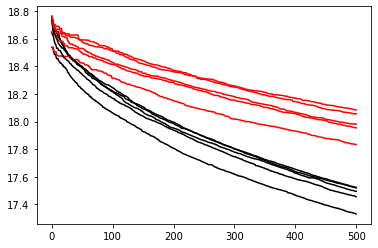

In [277]:
for i in tqdm(range(5)):
    do_seed(i)
    pop = torch.randn(101, 1000)*10.
    pops, fits, mrs, mrs_fits = re_gsmr(pop, ackley, 500, k=.5, k_mr=.1)
    plt.plot(fits.min(dim=-1).values,c='k')
    pops, fits, mrs, mrs_fits = re_gsmr(pop, ackley, 500, k=.5, k_mr=.5)
    plt.plot(fits.min(dim=-1).values,c='r')

In [243]:
mrs_fits.shape, mrs.shape

(torch.Size([501, 10, 10]), torch.Size([501, 10, 1]))

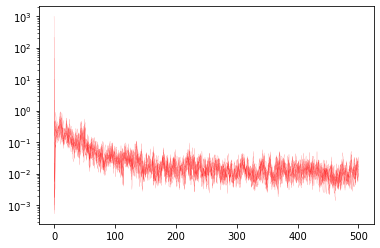

In [257]:
plt.plot(mrs[:, :, 0], c='r', linewidth=.1)
plt.yscale('log')

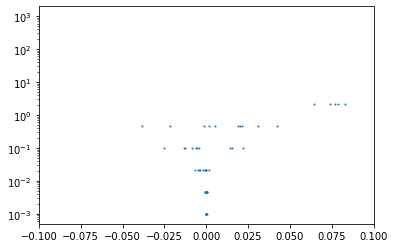

In [259]:
a = 1
plt.scatter(mrs_fits[0].flatten()[::a], mrs.repeat(1, 1, 10)[0].flatten()[::a], s=1)
plt.xlim(-.1, .1)
plt.yscale('log')

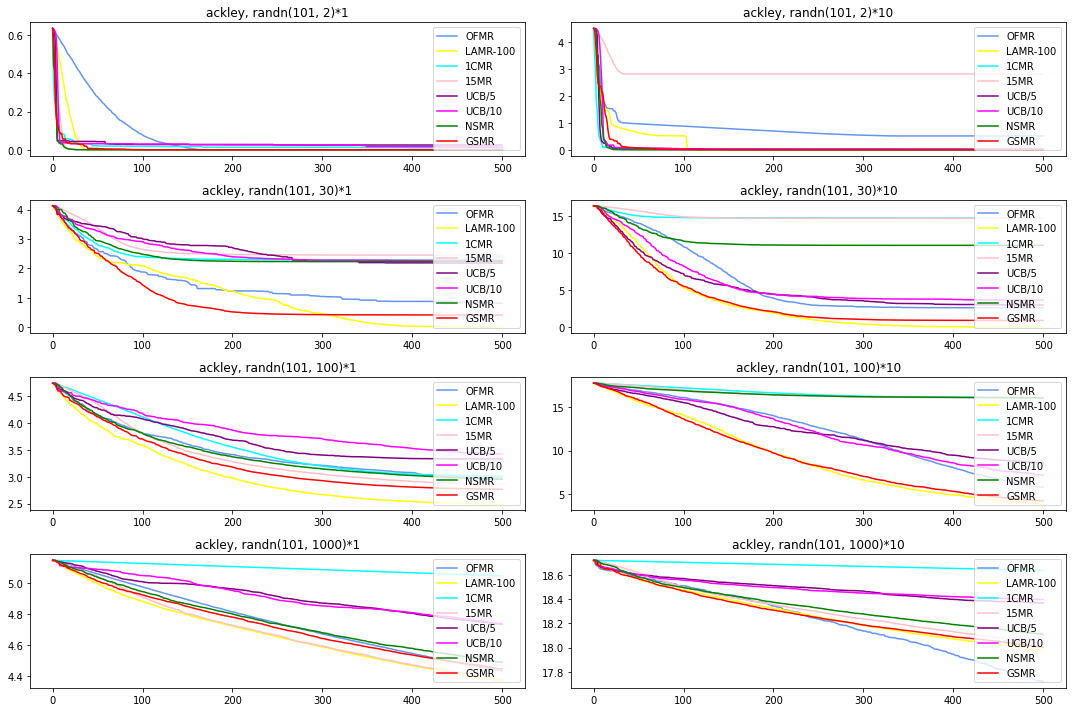

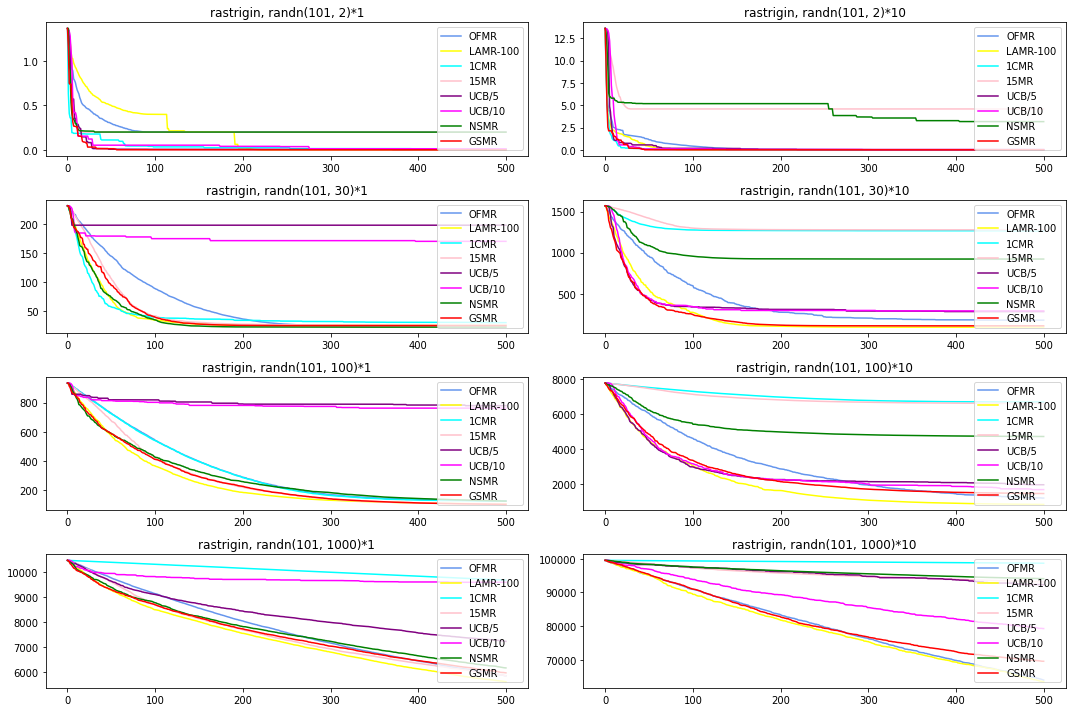

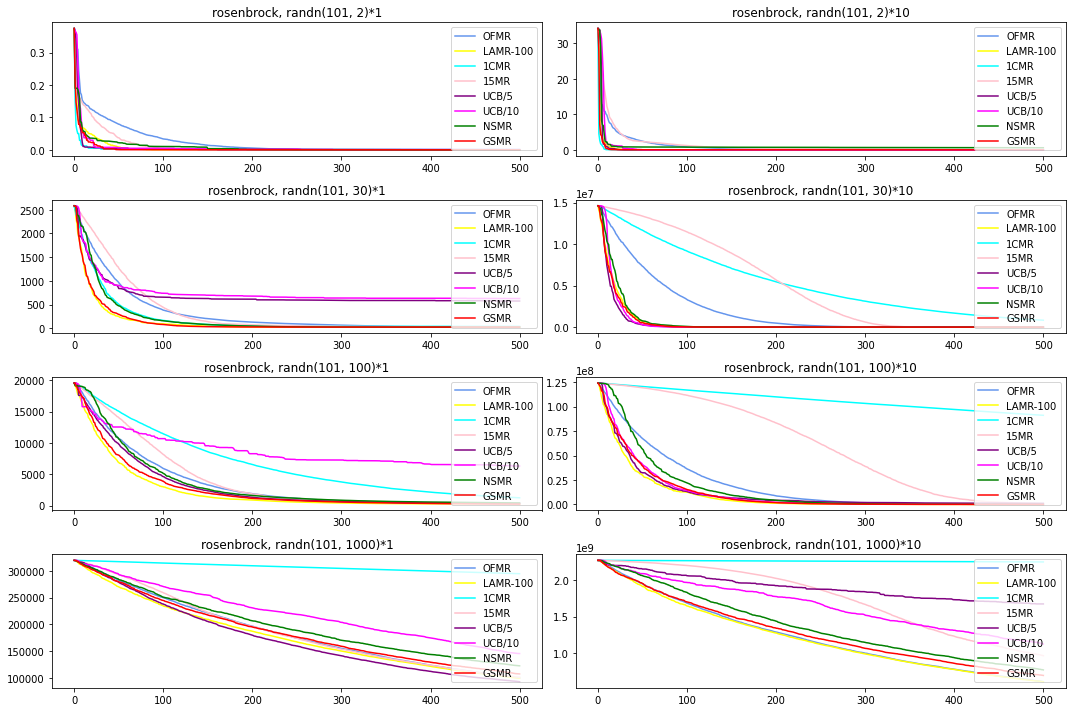

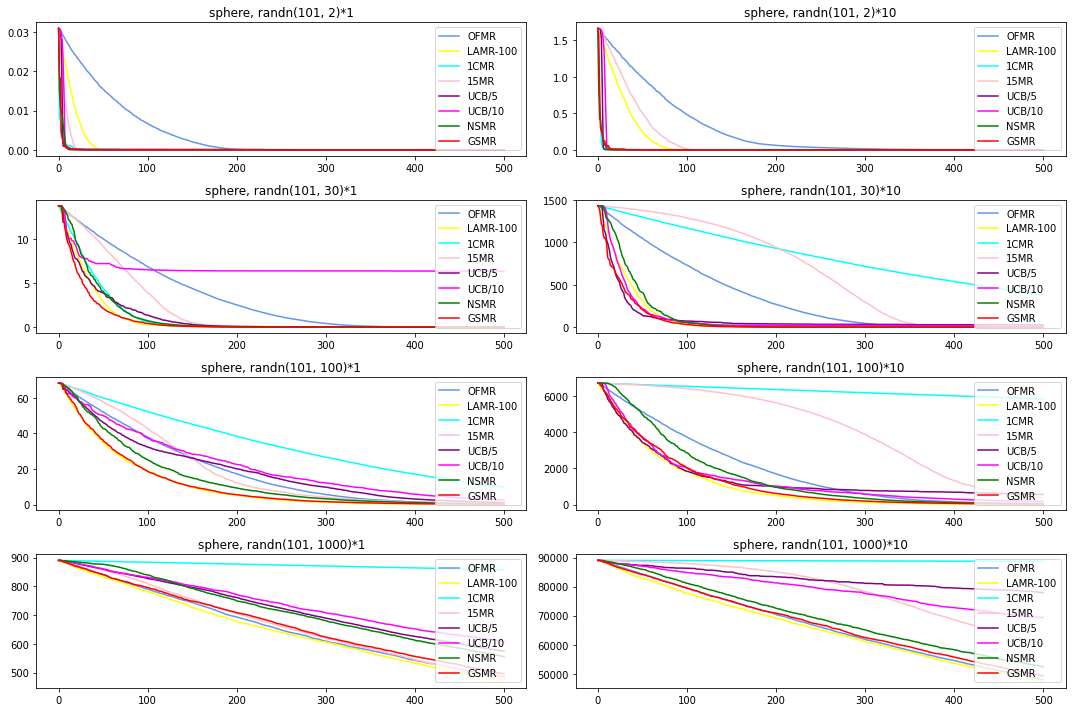

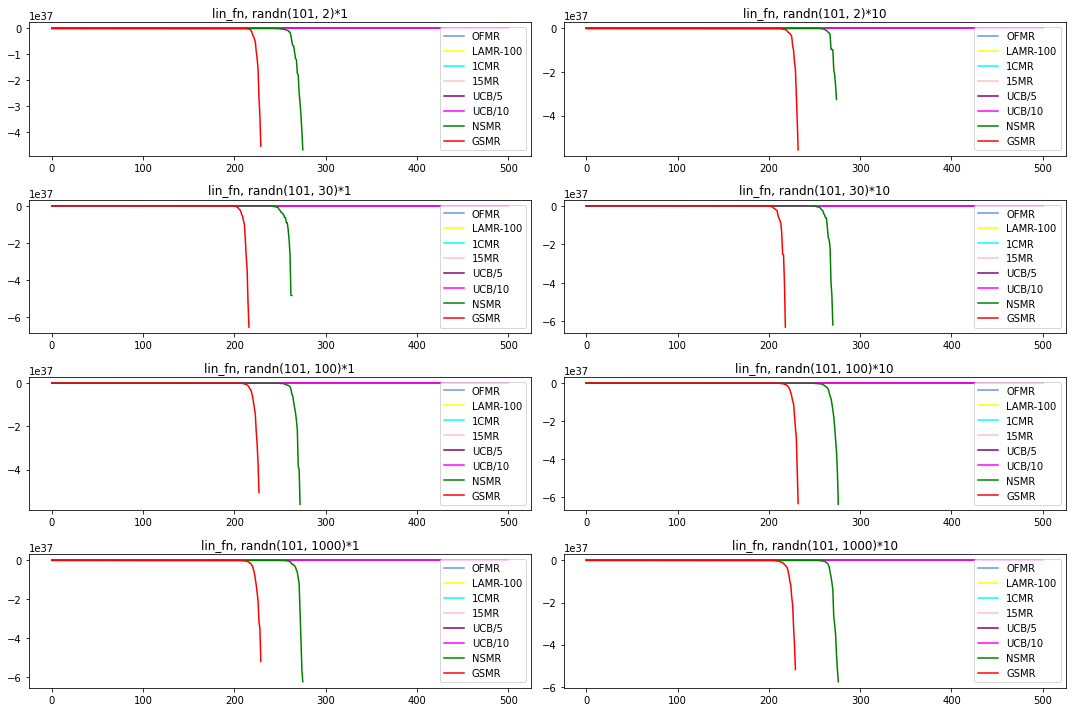

In [96]:
for optim_fn in data.coords['optim_fn']:
    plt.figure(figsize=(15, 10))
    i=1
    for n_dim in data.coords['n_dim']:
        for init_pop_var in data.coords['init_pop_var']:
            plt.subplot(len(data.coords['n_dim']), len(data.coords['init_pop_var']), i)
            i+=1
            for algo in data.coords['algo']:
                algo = str(algo.data)
                a = data.sel(algo=algo, optim_fn=optim_fn, 
                             n_dim=n_dim, init_pop_var=init_pop_var)
                b = torch.from_numpy(a.sel(fits_mrs='fits').data).float()
                viz.plot_mean_std(b, algo2label[algo], algo2color[algo], render_std=False, render_plots=False)
            plt.title(f'{optim_fn.item().__name__}, randn(101, {n_dim.item()})*{init_pop_var.item()}')
#             plt.gca().get_legend().remove()
    plt.tight_layout()
            



# Group size analysis

51 [ 1  2  5 10 25 50]


  0%|          | 0/6 [00:00<?, ?it/s]

101 [  1   2   4   5  10  20  25  50 100]


  0%|          | 0/9 [00:00<?, ?it/s]

201 [  1   2   4   5   8  10  20  25  40  50 100 200]


  0%|          | 0/12 [00:00<?, ?it/s]

401 [  1   2   4   5   8  10  16  20  25  40  50  80 100 200 400]


  0%|          | 0/15 [00:00<?, ?it/s]

601 [  1   2   3   4   5   6   8  10  12  15  20  24  25  30  40  50  60  75
 100 120 150 200 300 600]


  0%|          | 0/24 [00:00<?, ?it/s]

801 [  1   2   4   5   8  10  16  20  25  32  40  50  80 100 160 200 400 800]


  0%|          | 0/18 [00:00<?, ?it/s]

1001 [   1    2    4    5    8   10   20   25   40   50  100  125  200  250
  500 1000]


  0%|          | 0/16 [00:00<?, ?it/s]

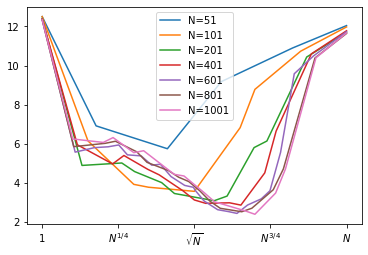

In [597]:
calc_factors = lambda x: np.array([i for i in range(1, x+1) if x%i==0])
optim_fn = ackley
n_gen = 500
n_seed = 5
n_dim = 100


# d = np.zeros((len(n_pops), len(optim_fns), len(n_dims), 
#                  len(init_pop_vars), n_seed, n_gen+1, 2))
# d = xr.DataArray(d, dims=('algo', 'optim_fn', 'n_dim', 
#                                 'init_pop_var', 'seed', 'gen', 'fits_mrs'),
#                     coords={'algo': algos, 
#                             'optim_fn': optim_fns,
#                             'n_dim': n_dims,
#                             'init_pop_var': init_pop_vars,
#                             'seed': list(range(n_seed)),
#                             'gen': list(range(n_gen+1)),
#                             'fits_mrs': ['fits', 'mrs'],
#                            })

n_pops = [51, 101, 201, 401, 601, 801, 1001]
# n_pops = [51]
for n_pop in n_pops:
    n_mutpops = calc_factors(n_pop-1)
    f = []
    print(n_pop, n_mutpops)
    for n_mutpop in tqdm(n_mutpops):
        for seed in range(n_seed):
            do_seed(seed+100)
            pop = torch.randn(n_pop, n_dim)*5
            pops, fits, mrs, _ = optim.run_evolution_ours(pop, optim_fn, n_gen, n_mutpop)
            f.append(fits)
    f = torch.stack(f).reshape(len(n_mutpops), n_seed, n_gen+1, n_pop)
    a = f.min(dim=-1).values[..., -1].T
    x = np.exp(np.log(n_mutpops)/np.log(np.max(n_mutpops)))
    plt.plot(x, a.mean(dim=0).numpy(), label=f'N={n_pop}')
ticks = np.e**np.linspace(0, 1, 5)
plt.xscale('log')
plt.gca().set_xticks(ticks)
plt.gca().set_xticklabels(['$1$', '$N^{1/4}$', '$\sqrt{N}$', '$N^{3/4}$', '$N$'])
plt.minorticks_off()
plt.legend()

X comes from std normal with sigma
$$E[X^n] = \sigma^n (n-1)!$$
$$f(x+\epsilon) - f(x) = \delta(x, \sigma) = \frac{f'(x)}{1!}\epsilon+\frac{f''(x)}{2!}\epsilon^2+\frac{f'''(x)}{3!}\epsilon^3$$
$$E[\delta(x, \sigma)] = \frac{f'(x)}{1!}E[\epsilon]+\frac{f''(x)}{2!}E[\epsilon^2]+\frac{f'''(x)}{3!}E[\epsilon^3]$$
$$E[\delta(x, \sigma)] = \sum_{n=1}^\infty \frac{f^{(n)}(x)}{n!}E[\epsilon^n]$$
$$E[\delta(x, \sigma)] = \sum_{n=1}^\infty \frac{f^{(n)}(x)}{n!}\sigma^n (n-1)!$$
$$E[\delta(x, \sigma)] = \sum_{n=1}^\infty \frac{f^{(n)}(x)}{n}\sigma^n$$




$$f_{\Delta| X, \Sigma}(\delta| x, \sigma)$$
$$f_{\Delta, \Sigma}(\delta, \sigma)$$


$$\epsilon_i\sim N(0, \sigma) \qquad i=0,\dots,q$$
$$\delta_i(x, \sigma) = \sum_{n=1}^\infty \frac{f^{(n)}(x)}{n!}\epsilon_i^n$$
$$E[\delta_i(x, \sigma)] = \sum_{n=1}^\infty \frac{f^{(n)}(x)}{n}\sigma^n$$
$$\min_i \delta_i(x, \sigma)] = 
\delta_\text{min}(x,\sigma) = 
\min_i \sum_{n=1}^\infty \frac{f^{(n)}(x)}{n!}\epsilon_i^n$$
$$E[\delta_\text{min}(x, \sigma)] = $$


$$P(\delta_\text{min} >a) = P(\delta_i > a \quad\forall i)=\Pi_i P(\delta_i>a)$$
$$F_{\delta_\text{min}}(a) = 1-\Pi_i P(\delta_i>a)$$
$$f_{\delta_\text{min}}(a) = -\frac{d}{da} \Pi_i P(\delta_i>a)$$
$$E[\delta_\text{min}] = -\int_{-\infty}^\infty a f_{\delta_\text{min}}(a) da =-\int_{-\infty}^\infty a \frac{d}{da} \left[\Pi_i P(\delta_i>a)\right] da$$

$$\int g(t) f'(t) dt = g(t)\int f'(t)dt - \int g'(t)\int f'(t)dt dt$$
$$\int g(t) f'(t) dt = a\int f'(a)da - \int \int f'(a)da da$$
$$\int g(t) f'(t) dt = af(a) - \int f(a) da$$




$$\int g(t) f'(t) dt = f'(t)\int g(t)dt - \int f''(t)\int g(t)dt dt$$